In [1]:
import pandas as pd
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats

from clusters import Spike
from preprocessing_pipeline import load_cluster

In [2]:
PATH = 'CelltypeClassification.mat'
mat = io.loadmat(PATH, simplify_cells=True)['sPV']

fn = mat['filename']
region = mat['region']
shankclu = mat['shankclu']
act = mat['act']
exc = mat['exc']
inh = mat['inh']

In [3]:
inds_inh = (inh == 1) * (act == 0) * (exc == 0)
inds_act = (act == 1) * (exc == 0)

names_inh = set([f"{fn[i[0]]}_{shankclu[i[0]][0]}_{shankclu[i[0]][1]}" for i in np.argwhere(inds_inh)])
names_act = set([f"{fn[i[0]]}_{shankclu[i[0]][0]}_{shankclu[i[0]][1]}" for i in np.argwhere(inds_act)])

names_combined = names_inh.union(names_act)

In [4]:
PATH = 'cluster_data/clusterData_no_light_29_03_22/0'
keep_columns = ['fwhm', 'trough2peak', 'firing_rate', 'unif_dist', 'label']

df = None
files = os.listdir(PATH)

for file in sorted(files):
    temp = pd.read_csv(PATH + '/' + file)
    
    if temp.name[0] not in names_combined:
        temp.label = 2
    elif temp.name[0] in names_inh:
        temp.label = 0
    else:
        temp.label = 1
        
    if df is None:
        df = temp
    else:
        df = df.append(temp)

df = df[keep_columns]

df.label = df.label.map({1: 'ACT', 0: 'INH', 2: 'PYR'})

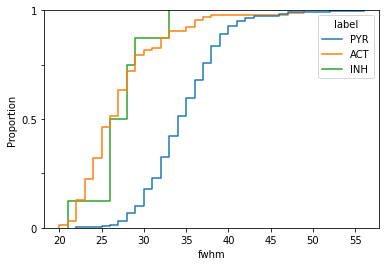

Median of PYR fwhm column is 34.0 [32.0, 37.0]
Median of ACT fwhm column is 26.0 [24.0, 29.0]
Median of INH fwhm column is 27.0 [26.0, 28.25]
[0.46236559 0.46236559 0.6344086  0.6344086  0.87096774 0.72043011
 0.46236559 0.01075269]
[26. 26. 28. 28. 33. 29. 26. 21.]


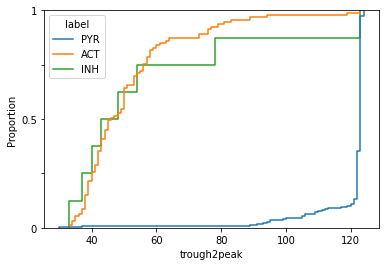

Median of PYR trough2peak column is 123.0 [122.0, 123.0]
Median of ACT trough2peak column is 46.0 [40.0, 56.0]
Median of INH trough2peak column is 45.5 [39.25, 60.0]
[0.51612903 0.21505376 0.92473118 0.35483871 0.98924731 0.06451613
 0.69892473 0.        ]
[ 48.  40.  78.  43. 123.  37.  54.  33.]


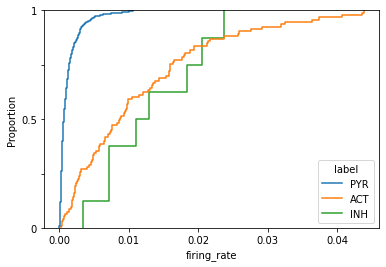

Median of PYR firing_rate column is 0.0006686820849674499 [0.0003520006055522299, 0.0014698247388822052]
Median of ACT firing_rate column is 0.008739410763276341 [0.0030933312968968074, 0.01602882010705063]
Median of INH firing_rate column is 0.011954786041144553 [0.007240474156026383, 0.018894648091259247]
[0.88172043 0.43010753 0.43010753 0.83870968 0.6344086  0.60215054
 0.2688172  0.80645161]
[0.02378814 0.00722145 0.00724681 0.02049851 0.01289489 0.01101468
 0.00339225 0.01836003]


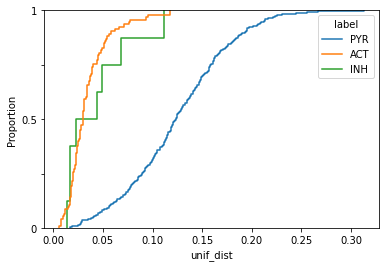

Median of PYR unif_dist column is 0.12343066992900475 [0.08971227847774707, 0.15921456205173112]
Median of ACT unif_dist column is 0.030161165964181808 [0.020217893550728963, 0.03987304390836333]
Median of INH unif_dist column is 0.03344895871448999 [0.017138527630080246, 0.053561222344891954]
[0.08602151 0.29032258 0.97849462 0.13978495 0.8172043  0.11827957
 0.77419355 0.92473118]
[0.01342627 0.02258547 0.11135279 0.01726475 0.04872013 0.01675987
 0.04431245 0.0680845 ]


In [5]:
for feature in df.columns:
    if feature == 'label':
        continue
    fig, ax = plt.subplots()
    _ = sns.ecdfplot(data=df, x=feature, hue="label", ax=ax)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(['0', '', '0.5', '', '1'])
    
    plt.show()
    
    col_pyr = df[feature][df.label == 'PYR'].to_numpy()
    col_act = df[feature][df.label == 'ACT'].to_numpy()
    col_inh = df[feature][df.label == 'INH'].to_numpy()
        
    pyr_median, pyr_prec25, pyr_prec75 = np.percentile(col_pyr, [50, 25, 75])
    act_median, act_prec25, act_prec75 = np.percentile(col_act, [50, 25, 75])
    inh_median, inh_prec25, inh_prec75 = np.percentile(col_inh, [50, 25, 75])
    
    print(f"Median of PYR {feature} column is {pyr_median} [{pyr_prec25}, {pyr_prec75}]")
    print(f"Median of ACT {feature} column is {act_median} [{act_prec25}, {act_prec75}]")
    print(f"Median of INH {feature} column is {inh_median} [{inh_prec25}, {inh_prec75}]")
    
    print(np.asarray([(col_act < elem).sum() for elem in col_inh]) / len(col_act))
    print(col_inh)

In [6]:
df_inh = df[df.label == 'INH']
df_act = df[df.label == 'ACT']
df_pyr = df[df.label == 'PYR']

In [10]:
print('INH VS ACT')
ps = []

for i, row in enumerate(df_inh.iterrows()):
    _, row = row
    fwhm_p = (df_act['fwhm'].to_numpy() >= row['fwhm']).sum() / len(df_act)
    t2p_p = (df_act['trough2peak'].to_numpy() >= row['trough2peak']).sum() / len(df_act)
    fire_rate_p = (df_act['firing_rate'].to_numpy() <= row['firing_rate']).sum() / len(df_act)
    unif_dist_p = (df_act['unif_dist'].to_numpy() >= row['unif_dist']).sum() / len(df_act)
    p = (fwhm_p * t2p_p * fire_rate_p * unif_dist_p) ** 0.25
    ps.append(p)

print(f"Median [IQR] of ps: {np.median(ps): .3f} [{np.quantile(ps, 0.25): .3f}, {np.quantile(ps, 0.75): .3f}]")
print(f"Range of ps: [{np.min(ps): .3f}, {np.max(ps): .3f}]")
print(f"Number of significant units is {np.sum(np.asarray(ps) < 0.05)}")

INH VS ACT
Median [IQR] of ps:  0.547 [ 0.268,  0.618]
Range of ps: [ 0.113,  0.677]
Number of significant units is 0


In [11]:
print('ACT VS ACT')
ps = []

for i, row in enumerate(df_act.iterrows()):
    _, row = row
    fwhm_p = (df_act['fwhm'].to_numpy() >= row['fwhm']).sum() / len(df_act)
    t2p_p = (df_act['trough2peak'].to_numpy() >= row['trough2peak']).sum() / len(df_act)
    fire_rate_p = (df_act['firing_rate'].to_numpy() <= row['firing_rate']).sum() / len(df_act)
    unif_dist_p = (df_act['unif_dist'].to_numpy() >= row['unif_dist']).sum() / len(df_act)
    p = (fwhm_p * t2p_p * fire_rate_p * unif_dist_p) ** 0.25
    ps.append(p)

print(f"Median [IQR] of ps: {np.median(ps): .3f} [{np.quantile(ps, 0.25): .3f}, {np.quantile(ps, 0.75): .3f}]")
print(f"Range of ps: [{np.min(ps): .3f}, {np.max(ps): .3f}]")
print(f"Number of significant units is {np.sum(np.asarray(ps) < 0.05)}")

ACT VS ACT
Median [IQR] of ps:  0.466 [ 0.309,  0.593]
Range of ps: [ 0.034,  0.922]
Number of significant units is 2


In [12]:
print('PYR VS ACT')
ps = []

for i, row in enumerate(df_pyr.iterrows()):
    _, row = row
    fwhm_p = (df_act['fwhm'].to_numpy() >= row['fwhm']).sum() / len(df_act)
    t2p_p = (df_act['trough2peak'].to_numpy() >= row['trough2peak']).sum() / len(df_act)
    fire_rate_p = (df_act['firing_rate'].to_numpy() <= row['firing_rate']).sum() / len(df_act)
    unif_dist_p = (df_act['unif_dist'].to_numpy() >= row['unif_dist']).sum() / len(df_act)
    p = (fwhm_p * t2p_p * fire_rate_p * unif_dist_p) ** 0.25
    ps.append(p)

print(f"Median [IQR] of ps: {np.median(ps): .3f} [{np.quantile(ps, 0.25): .3f}, {np.quantile(ps, 0.75): .3f}]")
print(f"Range of ps: [{np.min(ps): .3f}, {np.max(ps): .3f}]")
print(f"Number of significant units is {np.sum(np.asarray(ps) < 0.05)}")

PYR VS ACT
Median [IQR] of ps:  0.000 [ 0.000,  0.039]
Range of ps: [ 0.000,  0.104]
Number of significant units is 341
